In [1]:
## USE for Multi GPU Systems
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf

%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn
from sklearn import metrics

from sklearn.utils.multiclass import unique_labels

target_names = ["tap", "twotap", "swipeleft", "swiperight", "swipeup", "swipedown", "twoswipeup", "twoswipedown", "circle", "arrowheadleft", "arrowheadright", "checkmark", "flashlight", "l", "lmirrored", "screenshot", "rotate"]


target_names = ["Tap", "Two tap", "Swipe left", "Swipe right", "Swipe up", "Swipe down",
                "Two swipe up", "Two swipe down", "Circle", "Arrowhead left", "Arrowhead right",
                "$\checkmark$", "$\Gamma$", "L", "L mirrored", "S", "Rotate"]


tf.__version__

/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


'1.13.1'

In [2]:
df = pd.read_pickle("DataStudyEvaluation/df_lstm_norm50.pkl")

df.TaskID = df.TaskID % 17

x = np.concatenate(df.Blobs.values).reshape(-1,50,27,15,1)
x = x / 255.0

# convert class vectors to binary class matrices (one-hot notation)
num_classes = len(df.TaskID.unique())
y = tf.keras.utils.to_categorical(df.TaskID, num_classes)

labels = sorted(df.TaskID.unique())

In [3]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
#config = tf.ConfigProto(device_count = {"GPU": 1})

# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allow_growth=True
config.gpu_options.allocator_type = 'BFC'

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.3

# set session config
sess = tf.Session(config=config)
tf.keras.backend.set_session(sess)

In [4]:
model = tf.keras.models.load_model('./ModelSnapshots/LSTM-v2-00398.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [5]:
%%time
lst = []
batch = 100
for i in range(0, len(x), batch):
    _x = x[i : i+batch]
    lst.extend(model.predict(_x))

CPU times: user 30.4 s, sys: 3.28 s, total: 33.7 s
Wall time: 19.6 s


In [6]:
df["TaskIDPred"] = lst
df.TaskIDPred = df.TaskIDPred.apply(lambda x: np.argmax(x))

In [7]:
df_eval = df

In [8]:
print(sklearn.metrics.confusion_matrix(df_eval.TaskID.values, df_eval.TaskIDPred.values, labels=labels))
cm = sklearn.metrics.confusion_matrix(df_eval.TaskID.values, df_eval.TaskIDPred.values, labels=labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(np.round(cm,1))
print("Accuray: %.3f" % sklearn.metrics.accuracy_score(df_eval.TaskID.values, df_eval.TaskIDPred.values))
print("Recall: %.3f" % metrics.recall_score(df_eval.TaskID.values, df_eval.TaskIDPred.values, average="macro"))
#print("Precision: %.3f" % metrics.average_precision_score(df_eval.TaskID.values, df_eval.TaskIDPred.values))
print("F1-Score: %.3f" % metrics.f1_score(df_eval.TaskID.values, df_eval.TaskIDPred.values, average="macro"))
print(sklearn.metrics.classification_report(df_eval.TaskID.values, df_eval.TaskIDPred.values, target_names=target_names))

[[221   2   0   0   2   1   0   0   1   0   0   0   2   0   0   0  43]
 [  3 297   0   0   0   1   1   0   0   0   0   0   0   0   0   0  13]
 [  3   1 239   3   0   0   0   0   0   1   0   0   0   0  24   0   1]
 [  2   1   1 244   0   0   0   5   1   0   0   3   5   5   3   0   4]
 [  2   0   0   2 222   0   0   0   0   0   0   1  27   0   0   0   6]
 [  5   0   0   0   0 246   0   1   1   0   0   2   4  21   0   2   3]
 [  0   3   0   0   4   0 306   1   0   0   0   0   1   0   1   0   0]
 [  0   6   0   0   1  12   2 306   0   0   0   0   6   1   0   0   0]
 [  0   0   2   0   0   0   0   0 273   9   0  10   2   1   1   0   0]
 [  1   0   4   1   0   0   0   0  11 249   2   4   0   9   0   8   1]
 [  0   0   0   6   0   0   0   0   0   2 267   1   0   0   2  14   0]
 [  1   0   0   1   4   0   0   1  19   1   0 247   4   0   1   0   0]
 [  1   0   2   3  18   1   0   0   4   7   0   0 239   7   0   8   8]
 [  0   0   0   3   1   6   0   0   5   5   0   7   2 272   0   0   0]
 [  1 

Normalized confusion matrix


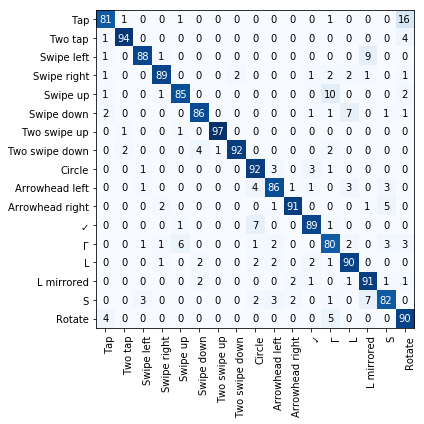

In [9]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes)
           #title=title,
           #ylabel='True label',
           #xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.0f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j]*100, fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.savefig("./out/conf_matrix.pdf", bbox_inches='tight', transparent=False, pad_inches=0)
    return ax

plot_confusion_matrix(df_eval.TaskID.values, df_eval.TaskIDPred.values, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')